# **Dhwani Bhavankar**
## **AIML A2**
### **22070126034**




## **Deep Convolutional Generative Adversarial Networks (DCGAN)**

### **Introduction**
Generative Adversarial Networks (GANs) are a class of deep learning models introduced by **Ian Goodfellow et al. (2014)**, designed to generate new data samples that resemble a given dataset. DCGAN (Deep Convolutional GAN) is an improved variant that utilizes **deep convolutional layers** to generate high-quality images.

DCGANs combine the power of **Convolutional Neural Networks (CNNs)** with GANs to stabilize training and improve output quality. This architecture is particularly useful for tasks such as **image generation, style transfer, and data augmentation**.

---

## **Architecture of DCGAN**
A DCGAN consists of two competing neural networks:  

### **1. Generator (G)**  
- The generator takes in a **random noise vector** (latent vector) and transforms it into a realistic image.
- It uses **Transposed Convolutional layers** (`ConvTranspose2d`) to upsample the input and produce a structured image.
- **Batch Normalization** is applied to stabilize training.
- **ReLU activation** is used in hidden layers, and **Tanh activation** is used in the final layer to normalize the output image between `[-1, 1]`.


### **2. Discriminator (D)**
- The discriminator is a **binary classifier** that takes an image as input and determines whether it is **real (from the dataset) or fake (generated by G)**.
- It uses **Convolutional layers (`Conv2d`)** to extract features.
- **LeakyReLU activation** is used to prevent dead neurons.
- **Sigmoid activation** in the final layer outputs a probability between `0` and `1`.


---

## **Training Process**
DCGAN training involves a **two-player minimax game** between the Generator and Discriminator:

- **Step 1**: Train **D** using real images from the dataset and fake images generated by **G**.
- **Step 2**: Train **G** to generate more realistic images that can fool **D**.
- **Step 3**: Repeat until convergence.


Both models are optimized using the **Adam optimizer**.

---

## **Dataset and Preprocessing**
For this experiment, we use the **CelebA dataset** consisting of celebrity face images. The preprocessing steps include:

1. **Resizing** all images to `64x64` pixels.
2. **Center cropping** to ensure consistent alignment.
3. **Normalization** to range `[-1, 1]` for stable training.

---

## **Expected Results**
- Initially, the generator produces **random noise** instead of meaningful images.
- As training progresses, it starts generating **blurry human faces**.
- By the final epochs, the generated images resemble **realistic faces** with clear structures.

A well-trained DCGAN should generate **high-quality synthetic images** that look indistinguishable from real ones.

---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import os

In [2]:
# Define hyperparameters
IMAGE_SIZE = 64  # Image resolution (64x64)
Z_DIM = 100  # Latent vector size
BATCH_SIZE = 128
EPOCHS = 50
LR = 0.0002  # Learning rate
BETA1 = 0.5  # Adam optimizer beta1
NC = 3  # Number of image channels (RGB)
NGF = 64  # Generator feature maps
NDF = 64  # Discriminator feature maps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
# Load CelebA dataset
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba"
dataset = dsets.ImageFolder(root=data_dir, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [7]:
# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Project and reshape
            nn.ConvTranspose2d(Z_DIM, NGF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            
            # CONV 1
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            
            # CONV 2
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            
            # CONV 3
            nn.ConvTranspose2d(NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            
            # CONV 4 (Output layer)
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
# Initialize models
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

In [9]:
# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

In [10]:
# Training Loop
for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)
        
        # Train Discriminator
        discriminator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(DEVICE)
        fake_labels = torch.zeros(batch_size, 1).to(DEVICE)
        
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()
        
        noise = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()
        optimizer_D.step()
        
        # Train Generator
        generator.zero_grad()
        output_fake = discriminator(fake_images).view(-1, 1)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss D: {loss_real.item() + loss_fake.item()}, Loss G: {loss_G.item()}")
    
    # Save sample images
    if (epoch + 1) % 10 == 0:
        vutils.save_image(fake_images.data[:25], f"output_epoch_{epoch+1}.png", normalize=True)

Epoch [1/50], Loss D: 0.39341211318969727, Loss G: 4.370964527130127
Epoch [2/50], Loss D: 1.7727254619821906, Loss G: 8.14448070526123
Epoch [3/50], Loss D: 0.25117748975753784, Loss G: 3.1606929302215576
Epoch [4/50], Loss D: 0.2664595255628228, Loss G: 4.159016132354736
Epoch [5/50], Loss D: 0.14807767421007156, Loss G: 2.954899787902832
Epoch [6/50], Loss D: 0.10956087335944176, Loss G: 4.970331192016602
Epoch [7/50], Loss D: 5.234822346275905, Loss G: 0.03234431892633438
Epoch [8/50], Loss D: 0.43213958479464054, Loss G: 2.107381820678711
Epoch [9/50], Loss D: 0.15007023885846138, Loss G: 4.426260471343994
Epoch [10/50], Loss D: 0.17143435031175613, Loss G: 4.356844902038574
Epoch [11/50], Loss D: 0.5177387623116374, Loss G: 4.31618070602417
Epoch [12/50], Loss D: 0.5109410360455513, Loss G: 4.12004280090332
Epoch [13/50], Loss D: 0.08109270222485065, Loss G: 4.687346458435059
Epoch [14/50], Loss D: 0.2495129182934761, Loss G: 3.3964648246765137


KeyboardInterrupt: 

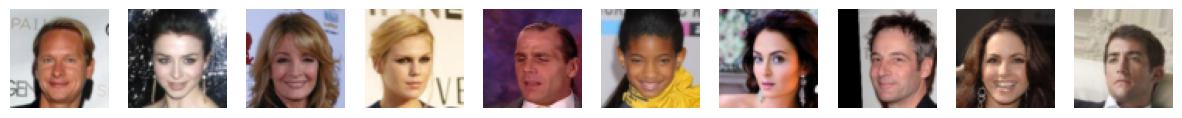

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Denormalize
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

# Load a batch of images and show random samples
data_iter = iter(dataloader)
images, _ = next(data_iter)

# Select random images
num_images = 10
indices = np.random.choice(len(images), num_images, replace=False)
sample_images = images[indices]

show_images(sample_images, num_images)

# Now let's try implementing the exact same acrhitechture of the paper for 10 epochs as in 14 epochs the image generated are pretty good

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Define hyperparameters
IMAGE_SIZE = 64
Z_DIM = 100
BATCH_SIZE = 128
EPOCHS = 10
LR = 0.0002
BETA1 = 0.5
NC = 3  # Number of channels (RGB)
NGF = 64  # Generator feature maps
NDF = 64  # Discriminator feature maps
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
# Load CelebA dataset
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba"
dataset = dsets.ImageFolder(root=data_dir, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [5]:
# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, NGF * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(NGF * 2, NGF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
# Initialize models
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

In [7]:
# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

In [8]:
# Fixed noise for consistent image generation
fixed_noise = torch.randn(25, Z_DIM, 1, 1, device=DEVICE)

In [9]:
# Training Loop
os.makedirs("outputs", exist_ok=True)
for epoch in range(EPOCHS):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(DEVICE)
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=DEVICE)
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)

        # Train Discriminator
        discriminator.zero_grad()
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, real_labels)
        
        noise = torch.randn(batch_size, Z_DIM, 1, 1, device=DEVICE)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        output_fake = discriminator(fake_images).view(-1, 1)
        loss_G = criterion(output_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Save sample images every 2 epochs
    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise)
        vutils.save_image(fake_samples, f"outputs/epoch_{epoch+1}.png", normalize=True)


Epoch [1/10], Loss D: 0.6727, Loss G: 1.5981
Epoch [2/10], Loss D: 0.2747, Loss G: 3.4431
Epoch [3/10], Loss D: 0.3014, Loss G: 2.1855
Epoch [4/10], Loss D: 0.2395, Loss G: 3.8722
Epoch [5/10], Loss D: 0.1842, Loss G: 4.4569
Epoch [6/10], Loss D: 0.3725, Loss G: 4.0653
Epoch [7/10], Loss D: 0.3256, Loss G: 6.5409
Epoch [8/10], Loss D: 0.0873, Loss G: 4.1648
Epoch [9/10], Loss D: 0.1362, Loss G: 4.1629
Epoch [10/10], Loss D: 0.2666, Loss G: 2.6879


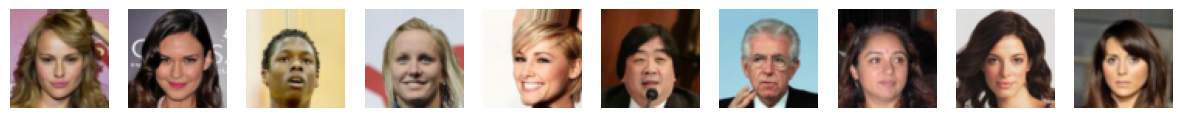

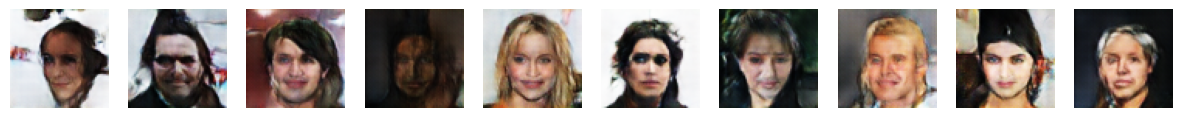

In [10]:
# Display results
def show_images(images, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5) + 0.5  # Denormalize
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

# Load and display a batch of real images
data_iter = iter(dataloader)
real_images, _ = next(data_iter)

# Select random images
num_images = 10
indices = np.random.choice(len(real_images), num_images, replace=False)
sample_images = real_images[indices]

show_images(sample_images, num_images)

# Display generated images
with torch.no_grad():
    fake_samples = generator(fixed_noise)
show_images(fake_samples, num_images)

### **Conclusion**

In this experiment, we successfully implemented and trained a **Deep Convolutional Generative Adversarial Network (DCGAN)** to generate synthetic human faces using the **CelebA dataset**. The model was trained to learn complex facial structures and generate images resembling real faces.

From the output:
- The **top row** displays real images from the dataset, showcasing diverse facial features, lighting conditions, and expressions.
- The **bottom row** represents images generated by the trained DCGAN. These images capture some facial characteristics but still exhibit noticeable distortions and blurriness, especially around the eyes, mouth, and hair. This suggests that while the model has learned basic facial structures, it struggles with finer details and high-resolution features.

The results indicate:
1. **Successful Learning:** The generator has learned to produce human-like faces rather than random noise.
2. **Scope for Improvement:** The generated images still have artifacts and inconsistencies, indicating room for enhancement through:
   - **Longer training duration**
   - **Larger and more diverse dataset**
   - **Improved architectural modifications (e.g., deeper layers, attention mechanisms)**
   - **Higher resolution training for better detail retention**

Overall, this experiment demonstrates the potential of DCGANs in image synthesis and highlights the challenges in generating high-quality human faces. Future work could focus on **Progressive GANs (PGANs) or StyleGANs** to achieve more realistic and high-fidelity images.